In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
#['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
log = pd.read_csv('data/driving_log.csv', usecols=['center', 'left', 'right', 'steering'])
log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


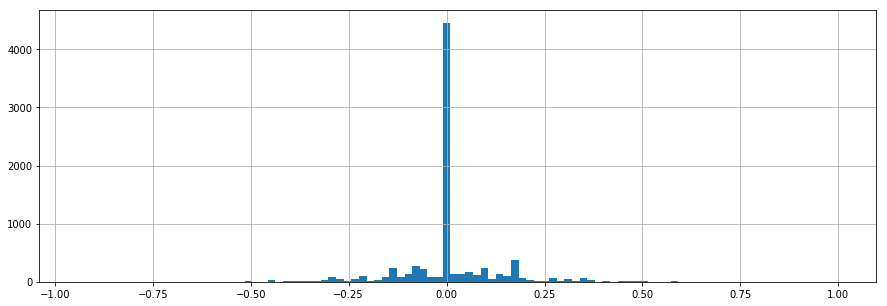

In [4]:
_ = log['steering'].hist(bins=100, figsize=(15,5))

In [5]:
def remove_zero_steerings(log, frac = 0.5):
    log_nonzero = log[log['steering']!=0]
    log_zero = log[log['steering']==0].sample(frac=1-frac)
    log = log_zero.append(log_nonzero)
    log = log.reset_index(drop=True)
    return log

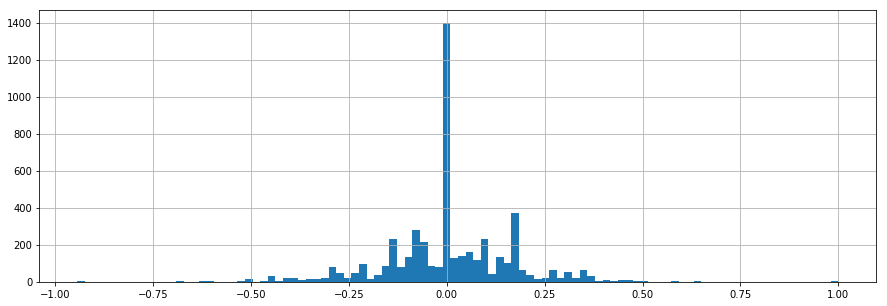

In [6]:
log = remove_zero_steerings(log, frac = 0.7)
_ = log['steering'].hist(bins=100, figsize=(15,5))

In [7]:
def preprocess(image):
    #image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[:,:,None]
    
    return image

In [8]:
def get_train_data(log, correction = 0.08):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename_c = 'data/'+row['center'].strip()
        filename_l = 'data/'+row['left'].strip()
        filename_r = 'data/'+row['right'].strip()

        image_c = preprocess(mpimg.imread(filename_c))
        image_l = preprocess(mpimg.imread(filename_l))
        image_r = preprocess(mpimg.imread(filename_r))

        steering_c = row['steering']
        steering_l = steering_c + correction
        steering_r = steering_c - correction

        images.extend([image_c, image_l, image_r])
        steerings.extend([steering_c, steering_l, steering_r])

        images.extend([cv2.flip(image_c, 1)[:,:,None], cv2.flip(image_l, 1)[:,:,None], cv2.flip(image_r, 1)[:,:,None]])
        steerings.extend([-steering_c, -steering_l, -steering_r])

    X_train, y_train = np.array(images), np.array(steerings)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    
    return X_train, y_train

In [9]:
train_log, validation_log = train_test_split(log, test_size=0.01)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

In [10]:
log.shape, train_log.shape, validation_log.shape

((4983, 4), (4933, 4), (50, 4))

In [11]:
def generator(sample_log, batch_size=32):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            
            end_offset = offset + batch_size
            if end_offset > n_rows:
                end_offset = n_rows
            
            batch_log = sample_log[offset : end_offset]

            X_train, y_train = get_train_data(batch_log)
            
            yield X_train, y_train 

In [12]:
# compile and train the model using the generator function
train_generator = generator(train_log, batch_size=128)
validation_generator = generator(validation_log, batch_size=128)

In [13]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,1)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2) 

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=5,
                                     verbose=1)

Epoch 1/5
4608/4933 [===========================>..] - ETA: 5s - loss: 0.0362 

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5376/4933 [================================] - 93s - loss: 0.0353 - val_loss: 0.0265
Epoch 2/5
5376/4933 [================================] - 79s - loss: 0.0280 - val_loss: 0.0166
Epoch 3/5
5376/4933 [================================] - 74s - loss: 0.0180 - val_loss: 0.0135

In [14]:
model.save('model.h5')

dict_keys(['val_loss', 'loss'])


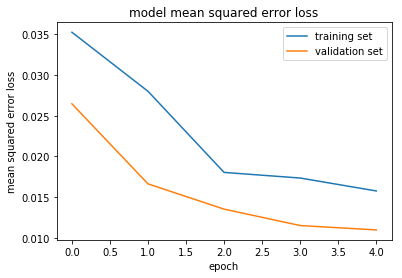

In [15]:
### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')